In [1]:
import sys, os, time
import logging
import torch
import pickle
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
pkg_path = '/home/rajeev-gupta/sensyn_ws/src/GD-MAE'
sys.path.insert(0, pkg_path)


In [2]:
from pcdet.models.detectors import GraphRCNN
from pcdet.config import cfg, cfg_from_yaml_file
from pcdet.datasets.kitti.kitti_dataset_waymo import KittiDataset


In [3]:
log_path = './test_logs.txt'
cfg_file = '/home/rajeev-gupta/sensyn_ws/src/GD-MAE/tools/cfgs/kitti_models/graph_rcnn_voi_waymo_kt.yaml'
ckpt_path = '/home/rajeev-gupta/sensyn_ws/src/GD-MAE/data/ckpts/graph_rcnn_voi_kitti.pth'
to_cpu = False
batch_size = 1
dist_test = False
workers = 4
root_data_path = Path('/home/rajeev-gupta/sensyn_ws/src/GD-MAE/data/waymo')

In [4]:
#Logger
def create_logger(log_file=None, rank=0, log_level=logging.INFO):
    logger = logging.getLogger(__name__)
    logger.setLevel(log_level if rank == 0 else 'ERROR')
    formatter = logging.Formatter('%(asctime)s  %(levelname)5s  %(message)s')
    console = logging.StreamHandler()
    console.setLevel(log_level if rank == 0 else 'ERROR')
    console.setFormatter(formatter)
    logger.addHandler(console)
    if log_file is not None:
        file_handler = logging.FileHandler(filename=log_file)
        file_handler.setLevel(log_level if rank == 0 else 'ERROR')
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)
    logger.propagate = False
    return logger

In [5]:
def load_data_to_gpu(batch_dict):
    for key, val in batch_dict.items():
        if not isinstance(val, np.ndarray):
            continue
        elif key in ['frame_id', 'metadata', 'calib', 'image_shape', 'image_pad_shape', 'image_rescale_shape', 'image_path']:
            continue
        else:
            batch_dict[key] = torch.from_numpy(val).float().cuda()


In [6]:
from torch.utils.data import DataLoader

def build_dataloader(dataset, batch_size, workers=4,
                     training=False, drop_last=False):
    sampler = None
    dataloader = DataLoader(
        dataset, batch_size=batch_size, pin_memory=True, num_workers=workers,
        shuffle=(sampler is None) and training, collate_fn=dataset.collate_batch,
        drop_last=drop_last, sampler=sampler, timeout=0
    )

    return dataloader


In [7]:
logger = create_logger(log_path)

In [8]:
cfg_from_yaml_file(cfg_file, cfg)

{'ROOT_DIR': PosixPath('/home/rajeev-gupta/sensyn_ws/src/GD-MAE'),
 'LOCAL_RANK': 0,
 'CLASS_NAMES': ['Car'],
 'DATA_CONFIG': {'DATASET': 'KittiDataset',
  'DATA_PATH': '../data/kitti',
  'BACKEND': {'NAME': 'HardDiskBackend'},
  'POINT_CLOUD_RANGE': [0, -75.2, -2, 150.4, 75.2, 4],
  'DATA_SPLIT': {'train': 'train', 'test': 'test'},
  'INFO_PATH': {'train': ['kitti_infos_train.pkl'],
   'test': ['kitti_infos_test.pkl']},
  'GET_ITEM_LIST': ['points', 'image', 'calib_matricies', 'gt_boxes2d'],
  'FOV_POINTS_ONLY': True,
  'ENABLE_SIMILAR_TYPE': True,
  'DATA_AUGMENTOR': {'DISABLE_AUG_LIST': ['placeholder'],
   'AUG_CONFIG_LIST': [{'NAME': 'random_world_flip',
     'PROBABILITY': 0.5,
     'ALONG_AXIS_LIST': ['x']},
    {'NAME': 'random_world_rotation',
     'PROBABILITY': 1.0,
     'WORLD_ROT_ANGLE': [-0.78539816, 0.78539816]},
    {'NAME': 'random_world_scaling',
     'PROBABILITY': 1.0,
     'WORLD_SCALE_RANGE': [0.95, 1.05]}]},
  'POINT_FEATURE_ENCODING': {'encoding_type': 'absolute_

In [9]:
dataset = KittiDataset(
        dataset_cfg=cfg.DATA_CONFIG,
        class_names=cfg.CLASS_NAMES,
        root_path=root_data_path,
        training=False,
        logger=logger,
    )

In [10]:
data_number = 100

In [11]:
get_dict = dataset.__getitem__(data_number)
get_dict

{'frame_id': '000100',
 'calib': <pcdet.utils.calibration_waymo.Calibration at 0x7f1b5b4df790>,
 'image': array([[[-0.72026956, -0.7874261 , -0.95772403],
         [-0.58440554, -0.63003814, -0.84491295],
         [-0.51647353, -0.5728062 , -0.7462032 ],
         ...,
         [-1.0327568 , -1.1737419 , -1.5076782 ],
         [-1.0327568 , -1.2023579 , -1.5499824 ],
         [-1.0191704 , -1.1880499 , -1.5358809 ]],
 
        [[-0.72026956, -0.7445021 , -0.92952126],
         [-0.57081914, -0.58711416, -0.77440596],
         [-0.4757143 , -0.5012662 , -0.66159487],
         ...,
         [-1.0191704 , -1.159434  , -1.4935768 ],
         [-1.0327568 , -1.2166659 , -1.5640838 ],
         [-1.0327568 , -1.2166659 , -1.5640838 ]],
 
        [[-0.77461517, -0.81604207, -0.9718254 ],
         [-0.61157835, -0.6443461 , -0.8026087 ],
         [-0.4757143 , -0.5155742 , -0.6333921 ],
         ...,
         [-0.9919976 , -1.1308179 , -1.465374  ],
         [-1.0191704 , -1.2023579 , -1.5499824 

In [12]:
get_dict['image'].shape

(384, 1280, 3)

In [13]:
get_dict['points'].shape

(5713, 4)

In [14]:
# get_dict['points'][0]

In [15]:
for key, val in get_dict.items():
    print(key)
    if type(val) == tuple:
        get_dict[key] = list(val)
    elif key == 'points':
        # add a zero column
        n = val.shape[0]
        z_col = np.zeros((n, 1), dtype=float)
        get_dict[key] = np.concatenate((z_col, val), axis = 1)
        continue
    elif key == 'image':
        # transpose (384, 1280, 3) to (3, 384, 1280)
        val_transposed = np.transpose(val, (2, 0, 1))
        get_dict[key] = val_transposed
        # print(get_dict[key].shape)
    elif key == 'transformation_2d_list' or key == 'transformation_2d_params':
        get_dict[key] = [val]
        continue
    get_dict[key] = np.array([get_dict[key]])
            
get_dict['batch_size'] = 1
# get_dict['points'][:, 4] = 1
# get_dict['points'][:, 4] /= 255

frame_id
calib
image
points
trans_lidar_to_cam
trans_cam_to_img
use_lead_xyz
transformation_2d_list
transformation_2d_params
image_rescale_shape
image_pad_shape
image_shape


In [16]:
get_dict

{'frame_id': array(['000100'], dtype='<U6'),
 'calib': array([<pcdet.utils.calibration_waymo.Calibration object at 0x7f1b5b4df790>],
       dtype=object),
 'image': array([[[[-0.72026956, -0.58440554, -0.51647353, ..., -1.0327568 ,
           -1.0327568 , -1.0191704 ],
          [-0.72026956, -0.57081914, -0.4757143 , ..., -1.0191704 ,
           -1.0327568 , -1.0327568 ],
          [-0.77461517, -0.61157835, -0.4757143 , ..., -0.9919976 ,
           -1.0191704 , -1.0599296 ],
          ...,
          [ 0.14926022,  0.14926022,  0.16284662, ..., -0.39419588,
           -0.39419588, -0.4077823 ],
          [ 0.16284662,  0.14926022,  0.14926022, ..., -0.38060948,
           -0.36702308, -0.36702308],
          [ 0.10850101,  0.09491461,  0.12208742, ..., -0.33985028,
           -0.29909107, -0.31267747]],
 
         [[-0.7874261 , -0.63003814, -0.5728062 , ..., -1.1737419 ,
           -1.2023579 , -1.1880499 ],
          [-0.7445021 , -0.58711416, -0.5012662 , ..., -1.159434  ,
        

In [17]:
get_dict['image'][0][0].dtype

dtype('float32')

trans mat analysis


In [18]:
l2c = get_dict['trans_lidar_to_cam'][0]
# vec = np.ones((4))
vec = np.zeros((4))
vec[3] = 1
l2c, vec

(array([[ 2.22044605e-16, -1.00000000e+00,  0.00000000e+00,
         -2.26140898e-02],
        [ 2.22044605e-16,  4.93038066e-32, -1.00000000e+00,
          2.11566401e+00],
        [ 1.00000000e+00,  2.22044605e-16,  2.22044605e-16,
         -1.54429412e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 array([0., 0., 0., 1.]))

In [19]:
rs = l2c @ vec
rs

array([-0.02261409,  2.11566401, -1.54429412,  1.        ])

In [20]:
rtn = l2c[:3, :3]



In [21]:
vx = np.array([1, 0, 0])
vy = np.array([0, 1, 0])
vz = np.array([0, 0, 1])
vecs = [v.reshape(3, 1) for v in [vx, vy, vz]]
vecs

[array([[1],
        [0],
        [0]]),
 array([[0],
        [1],
        [0]]),
 array([[0],
        [0],
        [1]])]

In [22]:
rs = [rtn @ v for v in vecs]
rs

[array([[2.22044605e-16],
        [2.22044605e-16],
        [1.00000000e+00]]),
 array([[-1.00000000e+00],
        [ 4.93038066e-32],
        [ 2.22044605e-16]]),
 array([[ 0.00000000e+00],
        [-1.00000000e+00],
        [ 2.22044605e-16]])]

In [23]:
get_dict['image'].shape

(1, 3, 384, 1280)

In [24]:
get_dict['points'].shape

(5713, 5)

In [25]:
from pcdet.utils.calibration_nuscene import encircle_pixel_in_image, point_cloud_to_image, image_to_point_cloud

complexity of algorithm  8048


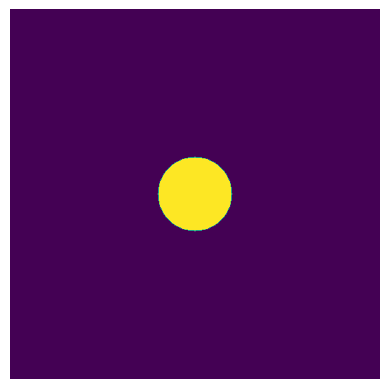

In [26]:
# test
image_arr = np.zeros((501, 501))
image_arr, _ = encircle_pixel_in_image(image_arr, [250, 250], 255, 50, print_complexity=True)
# print(image_arr)
plt.imshow(image_arr)
plt.axis('off')  # Optional: turn off axis
plt.show()

(5713, 2) 0.011843109843399233 1278.53210130352 97.18007719075445 382.8154616164588


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


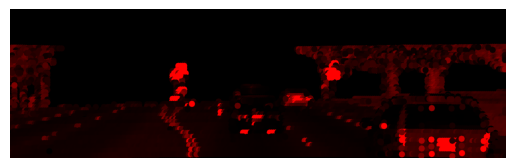

In [27]:
image_arr = point_cloud_to_image(get_dict, point_radii = 8, fill_depth_as_pixel_value=False)

In [28]:
image_arr.shape

(384, 1280, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


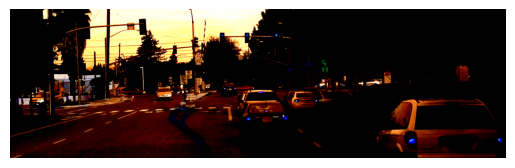

In [29]:
import matplotlib.pyplot as plt

# img = cv2.cvtColor(np.transpose(img[0], (1, 2, 0)), cv2.COLOR_BGR2RGB)
img = np.transpose(get_dict['image'][0], (1, 2, 0))
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

In [30]:
get_dict['image'].shape

(1, 3, 384, 1280)

In [31]:
len(cfg.CLASS_NAMES)

1

In [32]:
model = GraphRCNN(cfg.MODEL, num_class=len(cfg.CLASS_NAMES), dataset=dataset, logger=logger)

/media/rajeev-gupta/Drive250/conda_envs/new_graphrcnn/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180589158/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
2024-07-22 13:10:45,070   INFO  DLASeg is freezed
2024-07-22 13:10:45,071   INFO  DynVFE is freezed
2024-07-22 13:10:45,072   INFO  VoxelBackBone8x is freezed
2024-07-22 13:10:45,072   INFO  HeightCompression is freezed
2024-07-22 13:10:45,073   INFO  BaseBEVBackbone is freezed
2024-07-22 13:10:45,074   INFO  AnchorHeadSingle is freezed


In [33]:
with torch.no_grad():
    model.load_params_from_file(filename=ckpt_path, logger=logger, to_cpu=to_cpu)
    model.cuda()
    model.eval()
    time.sleep(2)

2024-07-22 13:10:45,079   INFO  ==> Loading parameters from checkpoint /home/rajeev-gupta/sensyn_ws/src/GD-MAE/data/ckpts/graph_rcnn_voi_kitti.pth to GPU
2024-07-22 13:10:45,510   INFO  ==> Done (loaded 518/518)


In [34]:
data_input = get_dict
# data_input = b_dict
torch.cuda.synchronize()
start_time = time.time()
load_data_to_gpu(data_input)
pred_dicts, ret_dict = model(data_input)
torch.cuda.synchronize()
end_time = time.time()
print('Inference Time: ', end_time-start_time)

pred_dicts

Inference Time:  1.7810118198394775


[{'pred_boxes': tensor([[ 4.2039e+01,  3.0102e-01, -8.8724e-01,  3.3636e+00,  1.3833e+00,
            1.4196e+00,  6.3788e+00],
          [ 3.8391e+01, -1.1195e+01,  3.6819e-02,  5.4709e+00,  2.0765e+00,
            2.2506e+00,  5.5342e+00],
          [ 6.8428e+01, -8.1795e+00, -5.8760e-01,  5.7821e+00,  2.1624e+00,
            2.5271e+00,  5.6552e+00],
          [ 2.0391e+01, -7.5584e+00, -1.1238e+00,  1.0147e+01,  3.0014e+00,
            9.7980e+00,  4.9948e+00]], device='cuda:0', grad_fn=<IndexBackward0>),
  'pred_scores': tensor([0.1642, 0.1561, 0.1480, 0.1302], device='cuda:0',
         grad_fn=<IndexBackward0>),
  'pred_labels': tensor([1, 1, 1, 1], device='cuda:0')}]

In [35]:
pred_boxes = pred_dicts[0]['pred_boxes'].cpu().detach().numpy()
pred_boxes

array([[ 4.2039021e+01,  3.0102310e-01, -8.8724029e-01,  3.3636038e+00,
         1.3832674e+00,  1.4196395e+00,  6.3787766e+00],
       [ 3.8390869e+01, -1.1194819e+01,  3.6819026e-02,  5.4708991e+00,
         2.0764909e+00,  2.2506320e+00,  5.5341506e+00],
       [ 6.8428345e+01, -8.1795187e+00, -5.8759713e-01,  5.7820573e+00,
         2.1623998e+00,  2.5271344e+00,  5.6552305e+00],
       [ 2.0390692e+01, -7.5583787e+00, -1.1237750e+00,  1.0147315e+01,
         3.0013769e+00,  9.7980175e+00,  4.9948411e+00]], dtype=float32)

In [36]:
index = f'{data_number:06d}'

In [37]:
image_bgr = dataset.get_image(index)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

In [38]:
image_bgr[0][0], image_rgb[0][0]

(array([51., 59., 52.], dtype=float32), array([52., 59., 51.], dtype=float32))

In [39]:
image_rgb = image_rgb / 255
image_bgr = image_bgr / 255
image_bgr[0]

array([[0.2       , 0.23137255, 0.20392157],
       [0.23921569, 0.27450982, 0.23529412],
       [0.25882354, 0.2901961 , 0.2627451 ],
       ...,
       [0.10980392, 0.1254902 , 0.05098039],
       [0.10980392, 0.11764706, 0.03921569],
       [0.11372549, 0.12156863, 0.04313726]], dtype=float32)

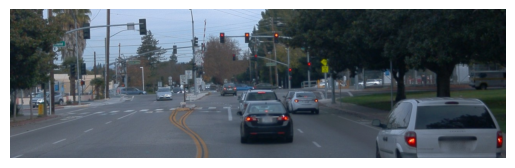

In [40]:
import matplotlib.pyplot as plt
plt.imshow(image_rgb)
# plt.imshow(image_bgr)
plt.axis('off')  # Hide the axis
plt.show()

In [41]:
calib = dataset.get_calib(index)
cam_to_img = calib.P2

In [42]:
cam_to_img

array([[2.07778589e+03, 0.00000000e+00, 6.40000000e+02, 0.00000000e+00],
       [0.00000000e+00, 2.07778589e+03, 1.92000000e+02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [43]:
def boxes3d_lidar_to_kitti_camera(boxes3d_lidar, calib):
    """
    :param boxes3d_lidar: (N, 7) [x, y, z, dx, dy, dz, heading], (x, y, z) is the box center
    :param calib:
    :return:
        boxes3d_camera: (N, 7) [x, y, z, l, h, w, r] in rect camera coords
    """
    import copy
    boxes3d_lidar_copy = copy.deepcopy(boxes3d_lidar)
    xyz_lidar = boxes3d_lidar_copy[:, 0:3]
    l, w, h = boxes3d_lidar_copy[:, 3:4], boxes3d_lidar_copy[:, 4:5], boxes3d_lidar_copy[:, 5:6]
    r = boxes3d_lidar_copy[:, 6:7]

    xyz_lidar[:, 2] -= h.reshape(-1) / 2
    xyz_cam = calib.lidar_to_rect(xyz_lidar)
    # xyz_cam[:, 1] += h.reshape(-1) / 2
    r = -r - np.pi / 2
    return np.concatenate([xyz_cam, l, h, w, r], axis=-1)


In [44]:
# convert lidar boxes to camera frame
pred_boxes_cam = boxes3d_lidar_to_kitti_camera(pred_boxes, calib)
pred_boxes_cam[0]

array([-0.32363719,  3.71272397, 40.49472642,  3.36360383,  1.41963947,
        1.3832674 , -7.94957304])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


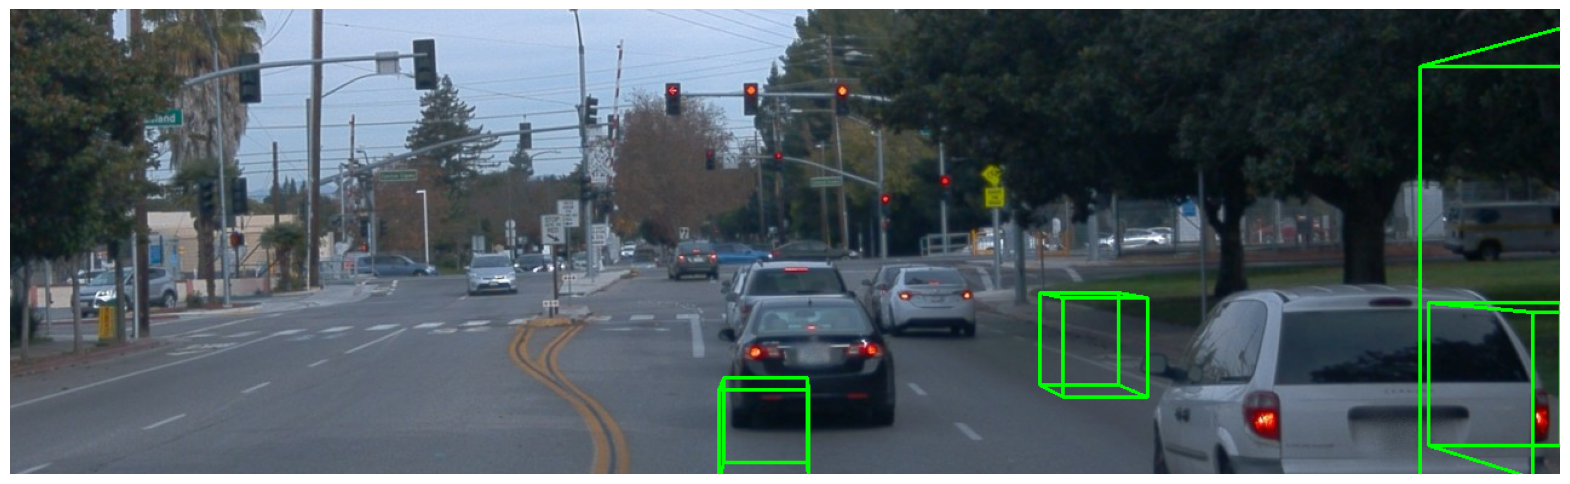

In [45]:
# Draw 3D Bounding Box
import copy
image_with_boxes = copy.deepcopy(image_rgb)
for line in pred_boxes_cam[:]:
# for line in [pred_boxes_cam[3]]:
    dims   = np.asarray([float(number) for number in line[3:6]])
    ## swap x, y, only required when reading from GD-MAE test - txt results
    tmp = dims[1]
    dims[1]=dims[0]
    dims[0]=tmp
    center = np.asarray([float(number) for number in line[0:3]])
    rot_y  = float(line[3]) + np.arctan(center[0]/center[2])#float(line[14])
    rot_y  = float(line[3]) + float(line[6]) + np.arctan(center[0]/center[2])
    rot_y = 0
    box_3d = []
    for i in [1,-1]:
        for j in [1,-1]:
            for k in [0,1]:
                point = np.copy(center)
                point[0] = center[0] + i * dims[1]/2 * np.cos(-rot_y+np.pi/2) + (j*i) * dims[2]/2 * np.cos(-rot_y)
                point[2] = center[2] + i * dims[1]/2 * np.sin(-rot_y+np.pi/2) + (j*i) * dims[2]/2 * np.sin(-rot_y)                  
                point[1] = center[1] - k * dims[0]
                point = np.append(point, 1)
                point = np.dot(cam_to_img, point)
                point = point[:2]/point[2]
                point = point.astype(np.int16)
                box_3d.append(point)
    for i in range(4):
        point_1_ = box_3d[2*i]
        point_2_ = box_3d[2*i+1]
        cv2.line(image_with_boxes, (point_1_[0], point_1_[1]), (point_2_[0], point_2_[1]), (0,255,0), 2)
    for i in range(8):
        point_1_ = box_3d[i]
        point_2_ = box_3d[(i+2)%8]
        cv2.line(image_with_boxes, (point_1_[0], point_1_[1]), (point_2_[0], point_2_[1]), (0,255,0), 2)

# Display the image using matplotlib
plt.figure(figsize=(20, 10))

plt.imshow(image_with_boxes)
plt.axis('off')  # Hide the axis
plt.show()

In [46]:
lst = [1, 2,5,5,7,5,4]
lst[-2:-1]

[5]